In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from neural_data import *

In [7]:
benchmark = NaturalScenesDataset()

In [8]:
print(f"There are {benchmark.stimulus_data.shape[0]} stimulus images")
benchmark.stimulus_data.head()

There are 1000 stimulus images


,index,image_name,image_path,coco_id,coco_supercategs,coco_categs,coco_areas,coco_captions
0,coco_264244,shared0014_nsd03627.png,/Users/facosta/Desktop/deepjuice/DeepNSD/neura...,264244,"['animal', 'person', 'furniture', 'electronic'...","['cat', 'person', 'bed', 'laptop', 'book', 'la...","[6110.812749999999, 40009.08360000001, 108675....",['Man laying on top of bed in green towel work...
1,coco_267699,shared0036_nsd04787.png,/Users/facosta/Desktop/deepjuice/DeepNSD/neura...,267699,"['vehicle', 'vehicle', 'vehicle', 'vehicle', '...","['car', 'car', 'car', 'car', 'bus', 'bus', 'bu...","[1692.3434000000013, 1032.3574500000004, 113.6...","[""a city's traffic with buses, cars and pedest..."
2,coco_268114,shared0040_nsd04931.png,/Users/facosta/Desktop/deepjuice/DeepNSD/neura...,268114,"['vehicle', 'vehicle', 'vehicle']","['boat', 'boat', 'boat']","[1825.7513000000001, 14098.474599999998, 113.5...","['A couple of white boats on the water.', 'thr..."
3,coco_531392,shared0045_nsd05302.png,/Users/facosta/Desktop/deepjuice/DeepNSD/neura...,531392,['indoor'],['vase'],[15927.302749999999],['A red vase sitting on top of a piano filled ...
4,coco_270278,shared0053_nsd05603.png,/Users/facosta/Desktop/deepjuice/DeepNSD/neura...,270278,['outdoor'],['stop sign'],[4444.39525],['A stop sign by a beach next to some placid w...


In [9]:
benchmark.metadata.head()

,subj_id,roi_name,roi_voxel_idx,voxel_reliability,roi_group,roi_level
voxel_id,,,,,,
8520,1,V1v,0,0.156360,Early Visual Cortex,Early Visual Cortex
8521,1,V1v,1,0.263088,Early Visual Cortex,Early Visual Cortex
8522,1,V1v,2,0.253195,Early Visual Cortex,Early Visual Cortex
8523,1,V1v,3,0.132281,Early Visual Cortex,Early Visual Cortex
8524,1,V1v,4,0.117597,Early Visual Cortex,Early Visual Cortex


In [10]:
cortical_regions = benchmark.metadata['roi_name'].unique()
print(f"There are {len(cortical_regions)} cortical regions:")
print(cortical_regions)

There are 19 cortical regions:
['V1v' 'V2v' 'V3v' 'V1d' 'V2d' 'V3d' 'hV4' 'OFA' 'FFA-1' 'FFA-2' 'OWFA'
 'VWFA-1' 'VWFA-2' 'EBA' 'FBA-1' 'FBA-2' 'OPA' 'PPA' 'RSC']


In [11]:
print(f"There are {benchmark.response_data.shape[0]} recorded voxels")
benchmark.response_data.head()

There are 8461 recorded voxels


,coco_264244,coco_267699,coco_268114,coco_531392,coco_270278,coco_10710,coco_273250,coco_538822,coco_283426,coco_549301,...,coco_123891,coco_14269,coco_178423,coco_202050,coco_386856,coco_553166,coco_123692,coco_198195,coco_414853,coco_442489
voxel_id,,,,,,,,,,,,,,,,,,,,,
8520,1.225205,0.590935,0.121206,0.549895,-0.340116,0.171882,0.945140,-0.242189,-0.501543,1.202971,...,0.678956,-1.262334,0.328617,-0.280216,0.895930,0.712224,0.610018,-0.234807,0.882929,-1.387336
8521,1.267595,0.743550,0.966085,0.378369,0.272476,0.196839,1.409024,0.576764,-0.727952,0.761293,...,1.256518,-0.542324,0.564668,0.222338,0.955391,0.274166,0.340416,-0.280754,0.964017,-0.737819
8522,0.997962,0.581113,1.135900,0.623025,0.023354,0.412820,0.926945,0.381630,-0.774300,0.571883,...,1.045422,-1.269126,0.573224,0.049556,1.105734,0.417626,0.099971,-0.058198,1.082593,-0.640127
8523,0.215511,-0.116404,0.419171,0.318863,-0.498560,1.054046,1.119572,0.778312,0.008422,0.428147,...,0.024606,-0.888920,0.995822,-0.039486,1.122496,-0.464239,-0.025626,0.113139,0.035508,-1.194936
8524,0.361521,-0.094618,0.313835,-0.282890,0.273159,0.276640,0.138759,0.417800,-0.151335,0.854391,...,-0.100879,-0.543191,-0.249918,0.490013,1.409335,-0.040840,-0.065341,0.216428,0.281004,-0.111645


Image description: f['Two beds in a hotel room with a window looking into the bathroom', 'a bed room with two beds near one another ', 'a couple of beds that are in a room', 'a motel room with two beds and a see through window into the batroom', 'Two beds are in a room with a glass window on the side. ']


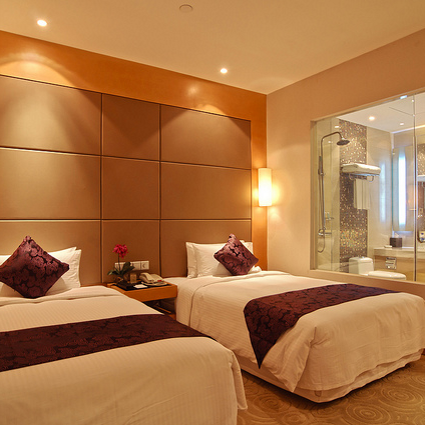

In [12]:
stimulus_id = 100

print(f"Image description: f{benchmark.stimulus_data.loc[stimulus_id]['coco_captions']}")
benchmark.view_sample_stimulus(stimulus_id)

In [13]:
benchmark.response_data.index

Index([ 8520,  8521,  8522,  8523,  8524,  8525,  8526,  8527,  8528,  8529,
       ...
       17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044],
      dtype='int64', name='voxel_id', length=8461)

In [14]:
benchmark.metadata.index

Index([ 8520,  8521,  8522,  8523,  8524,  8525,  8526,  8527,  8528,  8529,
       ...
       17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044],
      dtype='int64', name='voxel_id', length=8461)

In [15]:
benchmark.get_rdm_indices

<bound method NeuralDataset.get_rdm_indices of <neural_data.benchmarks.NaturalScenesDataset object at 0x103ea40a0>>

In [48]:
num_voxels = []
for region in benchmark.rdm_indices.keys():
    for subject in benchmark.rdm_indices[region]:
        num_voxels.append(len(benchmark.rdm_indices[region][subject]))

(array([8., 7., 2., 1., 0., 0., 0., 0., 0., 1.]),
 array([ 127. ,  314.5,  502. ,  689.5,  877. , 1064.5, 1252. , 1439.5,
        1627. , 1814.5, 2002. ]),
 <BarContainer object of 10 artists>)

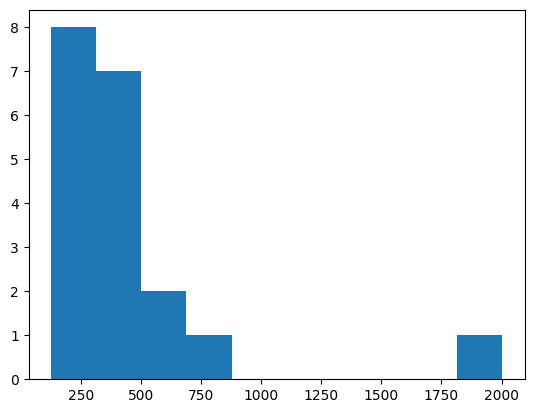

In [51]:
plt.hist(num_voxels)

In [16]:
benchmark.rdm_indices = benchmark.get_rdm_indices(['roi_name','subj_id'])

In [17]:
len(benchmark.rdm_indices['V1v'][1])

479

In [18]:
benchmark.rdms = benchmark.get_rdms(group_vars = ['roi_name', 'subj_id'])

In [19]:
benchmark.rdms['V1v'][1].shape

(1000, 1000)

In [20]:
benchmark.response_data.index

Index([ 8520,  8521,  8522,  8523,  8524,  8525,  8526,  8527,  8528,  8529,
       ...
       17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044],
      dtype='int64', name='voxel_id', length=8461)

In [21]:
v1v_idx = benchmark.metadata[benchmark.metadata['roi_name'] == 'V1v'].index

In [22]:
benchmark.response_data.loc[v1v_idx]

,coco_264244,coco_267699,coco_268114,coco_531392,coco_270278,coco_10710,coco_273250,coco_538822,coco_283426,coco_549301,...,coco_123891,coco_14269,coco_178423,coco_202050,coco_386856,coco_553166,coco_123692,coco_198195,coco_414853,coco_442489
voxel_id,,,,,,,,,,,,,,,,,,,,,
8520,1.225205,0.590935,0.121206,0.549895,-0.340116,0.171882,0.945140,-0.242189,-0.501543,1.202971,...,0.678956,-1.262334,0.328617,-0.280216,0.895930,0.712224,0.610018,-0.234807,0.882929,-1.387336
8521,1.267595,0.743550,0.966085,0.378369,0.272476,0.196839,1.409024,0.576764,-0.727952,0.761293,...,1.256518,-0.542324,0.564668,0.222338,0.955391,0.274166,0.340416,-0.280754,0.964017,-0.737819
8522,0.997962,0.581113,1.135900,0.623025,0.023354,0.412820,0.926945,0.381630,-0.774300,0.571883,...,1.045422,-1.269126,0.573224,0.049556,1.105734,0.417626,0.099971,-0.058198,1.082593,-0.640127
8523,0.215511,-0.116404,0.419171,0.318863,-0.498560,1.054046,1.119572,0.778312,0.008422,0.428147,...,0.024606,-0.888920,0.995822,-0.039486,1.122496,-0.464239,-0.025626,0.113139,0.035508,-1.194936
8524,0.361521,-0.094618,0.313835,-0.282890,0.273159,0.276640,0.138759,0.417800,-0.151335,0.854391,...,-0.100879,-0.543191,-0.249918,0.490013,1.409335,-0.040840,-0.065341,0.216428,0.281004,-0.111645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,0.809399,0.551736,0.660333,0.672658,-0.184463,0.523283,0.969880,0.515444,-0.022982,0.661752,...,0.448145,-1.199122,0.220109,-0.645589,1.396878,-0.183148,0.587521,1.316496,-0.164766,-1.124179
8995,0.755317,0.896822,0.548364,0.431190,-0.097195,0.504155,0.049716,0.732200,-0.040279,0.685911,...,0.055170,-1.107699,-0.132694,-0.012024,1.073715,0.232550,0.892772,1.145770,-0.146080,-1.186666
8996,0.842068,-0.003650,0.519372,0.623066,-0.188554,0.570396,0.476158,0.259451,-0.121765,0.201931,...,0.177941,-1.858974,-0.075552,-0.437687,1.108510,-0.178806,0.520232,1.604740,-0.466410,-0.903808


In [102]:
#from deepjuice import *

ModuleNotFoundError: No module named 'cupy'

In [29]:
from sklearn.decomposition import PCA
import torch

def compute_power_law_index(activations):
    # Perform PCA on the activations
    #pca = TorchPCA().fit(activations)
    pca = PCA()
    pca.fit(activations)
    eigvals = pca.explained_variance_
    ranks = torch.arange(1, len(eigvals)+1)

    log_ranks = torch.log(ranks.float())
    log_eigvals = torch.log(eigvals)

    # Convert to the format required for the normal equation
    x = torch.vstack((log_ranks, torch.ones_like(log_ranks))).T
    y = log_eigvals.view(-1, 1)

    # Solve the normal equations
    result = torch.linalg.lstsq(x, y)

    # result.solution[0] is the slope,
    # which is our alpha (power law index)

    alpha = result.solution[0].item()

    y_int = result.solution[1].item()

    return alpha, y_int, log_ranks, log_eigvals

In [30]:
import matplotlib.pyplot as plt
# Compute the power law index and get the log-ranks and log-eigenvalues
alpha, y_int, log_ranks, log_eigvals = compute_power_law_index(benchmark.response_data.loc[v1v_idx].to_numpy())

# Create a scatter plot of the log-ranks and log-eigenvalues
plt.scatter(log_ranks, log_eigvals, label='Data', alpha=0.5)

# Plot the line corresponding to the computed power law index
plt.plot(log_ranks, alpha * log_ranks + y_int, color='red', label=f'Power law index: {alpha:.2f}')

# Add labels and a legend
plt.xlabel('Log Rank')
plt.ylabel('Log Eigenvalue')
plt.legend()
plt.title('Log-Log Plot of Eigenvalues vs. Ranks')
plt.show()

TypeError: log(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq

def compute_power_law_index(activations):
    pca.fit(activations)
    eigvals = pca.explained_variance_
    eigvals = np.sort(eigvals)[::-1]
    ranks = np.arange(1, len(eigvals)+1)
    
    log_ranks = np.log(ranks)
    log_eigvals = np.log(eigvals)
    
    # Convert to the format required for the normal equation
    A = np.vstack([log_ranks, np.ones_like(log_ranks)]).T
    alpha, y_int = lstsq(A, log_eigvals, rcond=None)[0]
    
    return alpha, y_int, log_ranks, log_eigvals

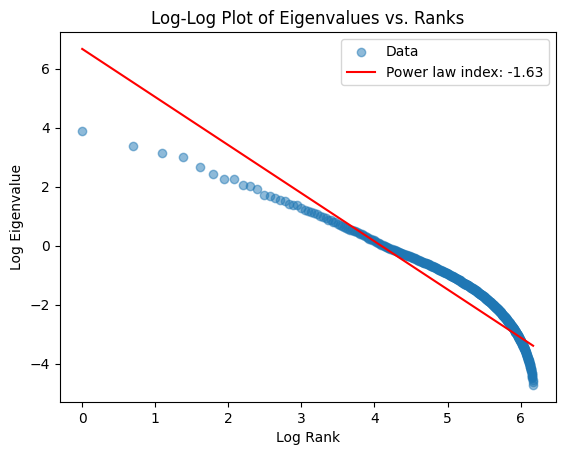

In [45]:
# Assuming benchmark.response_data.loc[v1v_idx].to_numpy() is a numpy array.
alpha, y_int, log_ranks, log_eigvals = compute_power_law_index(benchmark.response_data.loc[v1v_idx].to_numpy())

# Create a scatter plot of the log-ranks and log-eigenvalues
plt.scatter(log_ranks[:-1], log_eigvals[:-1], label='Data', alpha=0.5)

# Plot the line corresponding to the computed power law index
plt.plot(log_ranks, alpha * log_ranks + y_int, color='red', label=f'Power law index: {alpha:.2f}')

# Add labels and a legend
plt.xlabel('Log Rank')
plt.ylabel('Log Eigenvalue')
plt.legend()
plt.title('Log-Log Plot of Eigenvalues vs. Ranks')
plt.show()